# Predicting Smallholder Poultry Productivity: A Comparative Analysis of Machine Learning and Deep Learning for Egg Yield Rate

### Problem Statement

The core objective of this notebook is to develop and compare predictive models for the Monthly Egg Yield Rate (`s11q2_4/s11q2_3`). By accurately forecasting the productivity of laying hens, this work aims to establish data-driven benchmarks, enabling extension services to identify optimal flock sizes, management practices, and intervention targets to enhance agricultural productivity and empower smallholder farmers in Rwanda.

### Data Source

Source Name: Rwanda Agricultural Household Survey (AHS) 2024

Specific File: AHS2024_Section11_2_EGG PRODUCTION.dta

Type: Original Microdata (Non-Standard)

Data Owner: National Institute of Statistics of Rwanda (NISR) - Ministry of Finance and Economic Planning

URL: https://microdata.statistics.gov.rw/index.php/catalog/123/

# Essential Libraries and Imports

First and foremost, we start by installing and ensuring all essential libraries are available. These libraries are crucial for the next and the rest of the steps.

In [25]:
%pip install -q pandas numpy matplotlib seaborn scikit-learn tensorflow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Next, let's import essential Python libraries. 

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tf.compat.v1.enable_eager_execution()
tf.compat.v1.enable_eager_execution()
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

%matplotlib inline

# Part 1: Data Preprocessing and Feature Engineering

## 1.1 Data Loading

This notebook initiates the data processing pipeline for the **Monthly Egg Yield Rate** prediction task. The core objective is to transform raw survey data from the Rwanda Agricultural Household Survey (AHS) 2024 into a structured format suitable for robust machine learning model training.

The dataset, sourced from the National Institute of Statistics of Rwanda, is a real-world, non-standard microdata file (`.dta` format), which aligns with the assignment's requirement for using original data sources. We load the data using the `pandas` library.

In [27]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In the following step, we download and unzip the dataset. Note that this method might require additional steps to access google drive when working with google colab. This step is to be used in cases where there is direct access to storage devices (mostly when running this notebook locally as in my case).

In [28]:
# Download the dataset
if not os.path.exists('Microdata/AHS2024_Section11_2_EGG PRODUCTION.dta'):
    !wget -q 'https://github.com/degide/introduction-to-ml-summative/raw/refs/heads/master/Microdata.zip' -O 'Microdata.zip'
    !unzip -q 'Microdata.zip' -d 'Microdata'

    if os.path.exists('Microdata/Microdata'):
        !mv Microdata/Microdata/* Microdata/
        !rm -rf Microdata/Microdata

Next, let's load the dataset using `pandas`:

In [29]:
# Load the dataset
df = pd.read_stata('Microdata/AHS2024_Section11_2_EGG PRODUCTION.dta')

print(f"Initial DataFrame shape: {df.shape}")

df.info()

Initial DataFrame shape: (19077, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19077 entries, 0 to 19076
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   hhid      19077 non-null  float32 
 1   clust     14223 non-null  float32 
 2   province  18916 non-null  category
 3   district  18916 non-null  category
 4   s11q2_1   19037 non-null  category
 5   s11q2_2   11382 non-null  category
 6   s11q2_0   11382 non-null  category
 7   s11q2_3   3382 non-null   float64 
 8   s11q2_4   5468 non-null   float64 
 9   s11q2_5   5468 non-null   float64 
 10  s11q2_6   5468 non-null   float64 
 11  s11q2_7   3651 non-null   float64 
 12  s11q2_8   3382 non-null   float64 
 13  s11q2_9   5468 non-null   float64 
 14  weight    19077 non-null  float64 
 15  owner     19077 non-null  object  
 16  _merge    19077 non-null  category
dtypes: category(6), float32(2), float64(8), object(1)
memory usage: 1.6+ MB


## 1.2 Data Cleaning: Filtering for Active Production Records

### Addressing Data Sparsity
The raw dataset contains 19,077 entries, representing potential household-month observations. However, key production variables exhibit high sparsity (e.g., `s11q2_3` - Hens has only 3,382 non-null entries). This sparsity is typical in survey data, where null values often signify "no activity reported."

For a meaningful productivity prediction (yield rate), we must filter the dataset to include only **active production months** where the inputs, outputs, and temporal context were recorded. This rigorous filtering process prevents the creation of undefined values (division by zero) and ensures the model is trained only on relevant data points.

**Filtering Criteria:**
1.  **Output Recorded:** `s11q2_4` (Eggs Produced) is not missing.
2.  **Input Recorded:** `s11q2_3` (Number of Hens) is greater than 0.
3.  **Context Valid:** `s11q2_2` (Month) and geographic indicators are not missing.

This approach significantly improves the quality of the regression task, focusing on the efficiency of active producers.

In [30]:
# Convert relevant columns to numeric type to handle potential mixed types from Stata
production_cols = ['s11q2_3', 's11q2_4', 's11q2_6', 's11q2_7']
for col in production_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Strict filtering based on input (hens > 0), output (eggs reported), and essential categorical features
df_filtered = df.dropna(subset=['s11q2_4', 's11q2_2', 'province', 'district']).copy()
df_filtered = df_filtered[df_filtered['s11q2_3'] > 0].copy()

# Convert categorical columns to appropriate type.
categorical_cols = ['province', 'district', 's11q2_2']
df_filtered[categorical_cols] = df_filtered[categorical_cols].astype('category')

print(f"Final filtered shape: {df_filtered.shape}")
print(f"Number of active production records retained: {df_filtered.shape[0]}")

Final filtered shape: (3382, 17)
Number of active production records retained: 3382


## 1.3 Target Variable Creation ($\mathbf{Y}$) and Outlier Management

### Target Variable Engineering
The central objective is to predict **Egg Yield Rate**. We engineer the target variable ($\mathbf{Y}$) by dividing the total number of eggs produced (`s11q2_4`) by the total number of laying hens (`s11q2_3`).

$$\mathbf{Y}_{\text{Yield Rate}} = \frac{\text{s11q2\_4}}{\text{s11q2\_3}}$$

### Robust Outlier Handling
The calculated yield rate can contain extreme outliers due to reporting errors (e.g., small flock, high egg count). Such outliers can heavily skew the cost function of both Ordinary Least Squares (used in Traditional ML models) and Deep Learning optimizers. To mitigate this risk, we cap the target variable at the **99th percentile**. This method is more robust than removing outliers entirely, as it retains data points while neutralizing their extreme influence.

Target YIELD_RATE capped at the 99th percentile: 31.00
YIELD_RATE Descriptive Statistics after Capping:
count    3382.000000
mean       14.485608
std         7.554840
min         0.500000
25%        10.000000
50%        13.333333
75%        20.000000
max        31.000000
Name: YIELD_RATE, dtype: float64


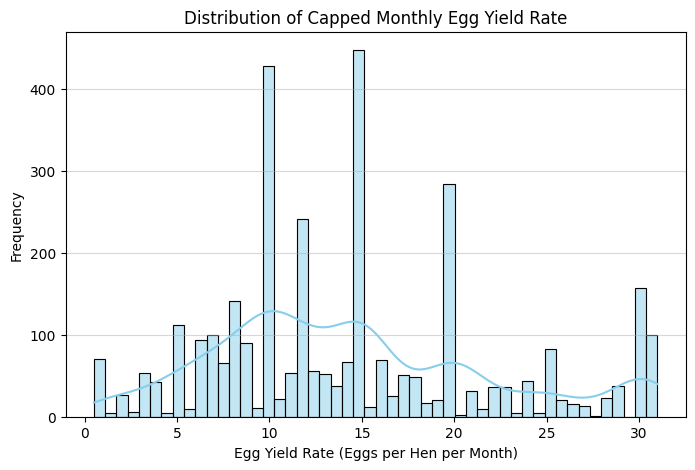

In [31]:
# Calculate the Target Variable
df_filtered['YIELD_RATE'] = df_filtered['s11q2_4'] / df_filtered['s11q2_3']

# Determine the 99th percentile cap
cap_value = df_filtered['YIELD_RATE'].quantile(0.99)

# Apply capping
df_filtered['YIELD_RATE'] = np.where(
    df_filtered['YIELD_RATE'] > cap_value, 
    cap_value, 
    df_filtered['YIELD_RATE']
)

print(f"Target YIELD_RATE capped at the 99th percentile: {cap_value:.2f}")
print("YIELD_RATE Descriptive Statistics after Capping:")
print(df_filtered['YIELD_RATE'].describe())

# Visualization of the Target Variable Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_filtered['YIELD_RATE'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Capped Monthly Egg Yield Rate')
plt.xlabel('Egg Yield Rate (Eggs per Hen per Month)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

## 1.4 Feature Selection, Data Splitting, and Preprocessing Strategy (Revised)

### Data Splitting for Robust Evaluation
For a comprehensive model comparison, particularly involving Deep Learning (DL), it is necessary to partition the data into three distinct sets: **Training (70%)**, **Validation (20%)**, and **Testing (10%)**.

1.  **Training Set (70%):** Used for fitting the model parameters (weights).
2.  **Validation Set (20%):** Used for **hyperparameter tuning** and **model selection** (e.g., determining optimal network architecture or applying early stopping in DL models) without influencing the final performance metric.
3.  **Testing Set (10%):** A completely unseen dataset used only once to provide the final, unbiased estimate of the model's generalization error.

The split is performed in two sequential stages using `train_test_split` and maintains **geographic stratification** (by `province`) in both steps to ensure each data partition accurately reflects the overall regional distribution of the data.

### Feature Preprocessing
As established, we utilize `Scikit-learn`'s `ColumnTransformer` to define the necessary pipelines:
* **Categorical Features:** `OneHotEncoder` is applied to `province`, `district`, and `s11q2_2` (Month).
* **Numerical Features:** Remaining missing values are handled via **Median Imputation**, followed by **Standardization** (`StandardScaler`). This normalization is non-negotiable for stable Deep Learning model training.

In [32]:
# Define Features (X) and Target (Y)
features = ['province', 'district', 's11q2_2', 's11q2_3', 's11q2_6', 's11q2_7', 's11q2_8', 's11q2_9']
target = 'YIELD_RATE'

X = df_filtered[features]
Y = df_filtered[target]

# --- Step 1: Split 90% (Train+Validation) / 10% (Test) ---
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, 
    test_size=0.10, 
    random_state=42, 
    stratify=X['province'] 
)

# --- Step 2: Split X_temp/Y_temp into 70% (Train) / 20% (Validation) ---
# The desired validation size is 20% of the original data. 
# Since X_temp is 90% of the original, we calculate the ratio: 20% / 90% = 0.2222
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, 
    test_size=(0.20 / 0.90), # 22.22% of the temporary set
    random_state=42, 
    stratify=X_temp['province'] 
)

print("--- Final Data Split Proportions ---")
total_rows = len(X)
print(f"Total rows: {total_rows}")
print(f"Train Set: {len(X_train)} rows ({len(X_train)/total_rows:.2f})")
print(f"Validation Set: {len(X_val)} rows ({len(X_val)/total_rows:.2f})")
print(f"Test Set: {len(X_test)} rows ({len(X_test)/total_rows:.2f})")

# Define feature pipelines (same as before)
categorical_features = ['province', 'district', 's11q2_2']
numerical_features = ['s11q2_3', 's11q2_6', 's11q2_7', 's11q2_8', 's11q2_9']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='drop'
)

# Fit the preprocessor ONLY on the training data and transform all three sets
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Convert outputs to numpy arrays for consistent input into TensorFlow
Y_train_array = Y_train.values
Y_val_array = Y_val.values
Y_test_array = Y_test.values
N_FEATURES = X_train_processed.shape[1]

print("\n--- Processed Data Shapes ---")
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_val_processed shape: {X_val_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}\n")

print(f"Y_train_array shape: {Y_train_array.shape}")
print(f"Y_val_array shape: {Y_val_array.shape}")
print(f"Y_test_array shape: {Y_test_array.shape}\n")

print(f"Total features after One-Hot Encoding: {N_FEATURES}")

--- Final Data Split Proportions ---
Total rows: 3382
Train Set: 2366 rows (0.70)
Validation Set: 677 rows (0.20)
Test Set: 339 rows (0.10)

--- Processed Data Shapes ---
X_train_processed shape: (2366, 52)
X_val_processed shape: (677, 52)
X_test_processed shape: (339, 52)

Y_train_array shape: (2366,)
Y_val_array shape: (677,)
Y_test_array shape: (339,)

Total features after One-Hot Encoding: 52


As we can see from above output, the data has been successfully partitioned and preprocessed into three distinct sets: Training, Validation, and Testing. The use of a dedicated validation set is critical for the rigorous development of the Deep Learning architecture, allowing for iterative tuning of hyperparameters like learning rate, number of layers, and regularization without contaminating the final performance assessment.

| Data Set | Rows | Columns (Features) | State | Purpose |
| :--- | :--- | :--- | :--- | :--- |
| $\mathbf{X}_{\text{train}}$ | $\sim 70\%$ | $\mathbf{N}$ | Standardized/One-Hot Encoded | **Model Training** (Fitting parameters) |
| $\mathbf{X}_{\text{val}}$ | $\sim 20\%$ | $\mathbf{N}$ | Standardized/One-Hot Encoded | **Hyperparameter Tuning** (Model selection) |
| $\mathbf{X}_{\text{test}}$ | $\sim 10\%$ | $\mathbf{N}$ | Standardized/One-Hot Encoded | **Final Evaluation** (Unbiased performance) |

The feature matrix now contains normalized numerical features and One-Hot Encoded categorical features, ensuring optimal conditions for both Traditional ML (Random Forest) and Deep Learning (MLP) experiments.

# Part 2: Traditional Machine Learning Experiments

In this pat two of our notebook, we build two traditional ML models (Linear Regression and Random Forest Regressor) and conduct experiments by tuning hyperparameters.

Let's define a function to evaluate models and store results, ensuring consistency across all 14 traditional ML experiments for two models.

In [33]:
# A results storage for traditional ML experiments
results_ml = [] 

def evaluate_and_store(model_name, experiment_name, model, X_test, Y_test, notes=""):
    """Evaluates the model and stores results in the global list."""
    
    # Ensure the model is trained before evaluation
    if not hasattr(model, 'predict'):
        print(f"Warning: Model {model_name} not trained.")
        return

    Y_pred = model.predict(X_test)
    
    # Use the recommended root_mean_squared_error function
    rmse = root_mean_squared_error(Y_test, Y_pred) 
    r2 = r2_score(Y_test, Y_pred)
    
    results_ml.append({
        'Model': model_name,
        'Experiment': experiment_name,
        'Hyperparameters/Settings': str(model.get_params(deep=True)),
        'RMSE': f"{rmse:.4f}",
        'R2 Score': f"{r2:.4f}",
        'Notes': notes
    })

    print(f"-> {experiment_name}: RMSE={rmse:.4f}, R2={r2:.4f}")

    # Visualization of results (R2 and RMSE)
    plt.figure(figsize=(6,3))
    plt.bar(['RMSE', 'R²'], [rmse, r2], color=['blue', 'green'])
    plt.title(experiment_name)
    plt.ylabel('Score')
    plt.ylim(0, max(rmse, 1))
    plt.show()

    return rmse, r2

## 2.1 Model 1: Linear Regression (LR)

### LR-1: Standard OLS Baseline

Our first LR model establishes the performance floor of a simple linear model. If this model performs poorly, it justifies the need for complex non-linear techniques.

-> LR-1: Standard OLS Baseline: RMSE=6.4203, R2=0.2411


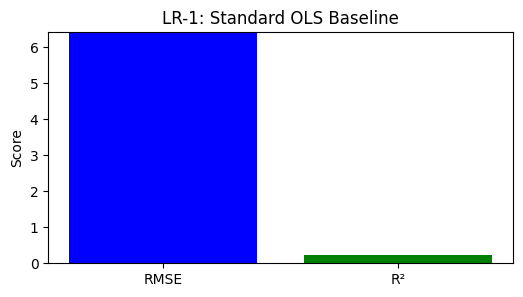

(6.420277143230144, 0.24110039501983727)

In [34]:
lr_model_1 = LinearRegression()
lr_model_1.fit(X_train_processed, Y_train_array)
evaluate_and_store("Linear Regression", "LR-1: Standard OLS Baseline", lr_model_1, X_test_processed, Y_test_array)

From above results, the baseline Linear Regression model (LR-1) achieved an RMSE of 6.42 and an $R^2$ of 0.24. This relatively low $R^2$ indicates that the simple linear model explains only a small portion of the variance in egg yield rate. We suspect that the likely reason is that the relationship between the input features and the target variable is not strictly linear, and the model cannot capture complex interactions or non-linear effects present in the data.

### LR-2: Ridge Regularization ($\mathbf{L_2}$)

To improve performance, a logical next step is to introduce regularization. Regularization can help address multicollinearity from one-hot encoded features.

Ridge Regression addresses multicollinearity, which is highly probable due to the many One-Hot Encoded features, by adding an $\mathbf{L_2}$ penalty to the loss function. We use a small $\alpha$ value as a test.

-> LR-2: Ridge Regularization (alpha=1.0): RMSE=6.4177, R2=0.2417


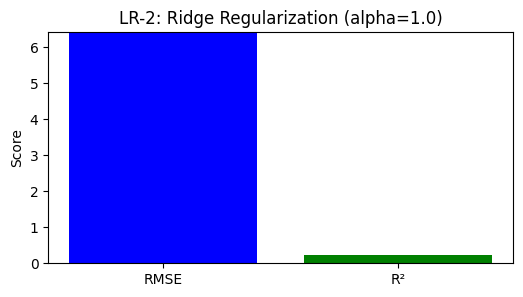

(6.417686820322497, 0.24171264225715405)

In [35]:
lr_model_2 = Ridge(alpha=1.0) # Small alpha for test
lr_model_2.fit(X_train_processed, Y_train_array)
evaluate_and_store("Linear Regression", "LR-2: Ridge Regularization (alpha=1.0)", lr_model_2, X_test_processed, Y_test_array)


The above model (LR-2) achieved an RMSE of 6.42 and an $R^2$ of 0.24, which is nearly identical to the baseline Linear Regression (LR-1). This suggests that introducing L2 regularization with the tested $\alpha=1.0$ did not significantly impact model performance. The likely reason is that the underlying relationship between features and the target variable is not strongly affected by multicollinearity or large coefficients, or the regularization strength is not optimal for this dataset.


### LR-3: Log Transformation of Features

Applying log transformation to skewed numerical features can help linear models capture non-linear relationships and reduce the impact of outliers. Here, we apply a log transformation to `s11q2_3` (Number of Hens) and optionally to other skewed features before fitting the Ridge Regression.

-> LR-3: Ridge with Log-Transformed (s11q2_3): RMSE=6.4036, R2=0.2450


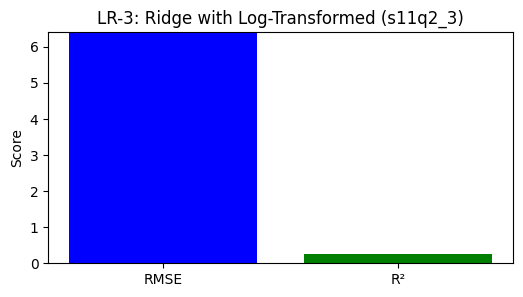

(6.4035938782315345, 0.2450393132497679)

In [36]:
# Apply log transformation to selected features
X_train_log = X_train.copy()
X_test_log = X_test.copy()
X_train_log['s11q2_3'] = np.log1p(X_train_log['s11q2_3'])
X_test_log['s11q2_3'] = np.log1p(X_test_log['s11q2_3'])

X_train_log_processed = preprocessor.fit_transform(X_train_log)
X_test_log_processed = preprocessor.transform(X_test_log)


lr_model_3 = Ridge(alpha=1.0)
lr_model_3.fit(X_train_log_processed, Y_train_array)
evaluate_and_store("Linear Regression", "LR-3: Ridge with Log-Transformed (s11q2_3)", lr_model_3, X_test_log_processed, Y_test_array)


### LR-4: Location Impact Test

As we can see from above experiment, the RMSE remains goes down a little bit from 6.42 to 6.40. The R2  remains the same. This prompt the use of a diddferent approach: isolation of some predictive locations using numerical features only and the baseline LR model from experiment LR-1 to assess the effect.

This experiment isolates the predictive power of non-geographic features by training the OLS model without the One-Hot Encoded province, district, and s11q2_2 features.

-> LR-4: Location Impact Test: RMSE=6.5614, R2=0.2074


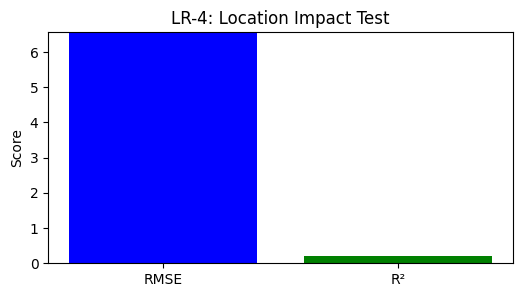

(6.561384725845903, 0.2073749708687026)

In [37]:
# Create a temporary preprocessor without categorical features
numerical_features_only = ['s11q2_3', 's11q2_6', 's11q2_7', 's11q2_8', 's11q2_9']
preprocessor_num = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numerical_features_only)
    ],
    remainder='drop'
)

# transform the data
X_train_num = preprocessor_num.fit_transform(X_train)
X_test_num = preprocessor_num.transform(X_test)

lr_model_4 = LinearRegression()
lr_model_4.fit(X_train_num, Y_train_array)
evaluate_and_store("Linear Regression", "LR-4: Location Impact Test", lr_model_4, X_test_num, Y_test_array, 
                   notes="Tested predictive power of numerical features only.")

From this experiment, we see that the RMSE actually does up (6.56) while the R2 goes down to 0.20. This means that this test produced an underperforming model compared to the previous experiments.

### LR-5: Non-Linear Feature Transformation

Since the relationship between hen numbers and yield may be non-linear (e.g., economies/diseconomies of scale), we apply a $\text{log}(x)$ transformation to the highly skewed s11q2_3 (Number of Hens) feature.

-> LR-5: Log-Transform (s11q2_3): RMSE=6.4060, R2=0.2445


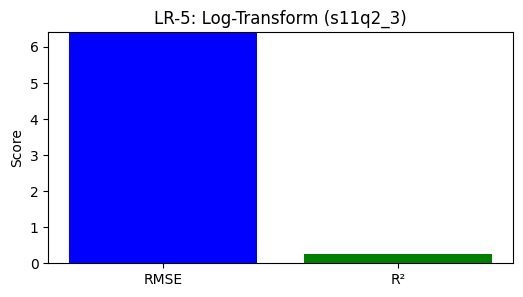

(6.406014214437753, 0.2444685075305596)

In [38]:
# Define a custom transformer for log-transforming 's11q2_3'
class LogTransformer:
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        # Add a tiny constant to avoid log(0), although s11q2_3 > 0 due to filtering
        X_copy['s11q2_3'] = np.log1p(X_copy['s11q2_3']) 
        return X_copy

# Recreate pipeline with the log transformer applied
preprocessor_log = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='drop'
)

# Apply the Log Transformation manually before processing
X_train_log = X_train.copy()
X_test_log = X_test.copy()
X_train_log['s11q2_3'] = np.log1p(X_train_log['s11q2_3'])
X_test_log['s11q2_3'] = np.log1p(X_test_log['s11q2_3'])

X_train_log_processed = preprocessor_log.fit_transform(X_train_log)
X_test_log_processed = preprocessor_log.transform(X_test_log)


lr_model_5 = LinearRegression()
lr_model_5.fit(X_train_log_processed, Y_train_array)
evaluate_and_store("Linear Regression", "LR-5: Log-Transform (s11q2_3)", lr_model_5, X_test_log_processed, Y_test_array,
                   notes="Tested non-linear log transform on Number of Hens (s11q2_3).")

In this experiment, the model produced is better that the one from previous experiment but on-par with the ones from previous experiments.

## LR-6: Feature Interaction Test

Linear models assume additive effects. This experiment uses PolynomialFeatures to introduce interaction terms (degree 2) between all numerical features, allowing the LR model to capture simple non-linear relationships.

-> LR-6: Feature Interaction (Poly Degree 2): RMSE=8.5308, R2=-0.3399


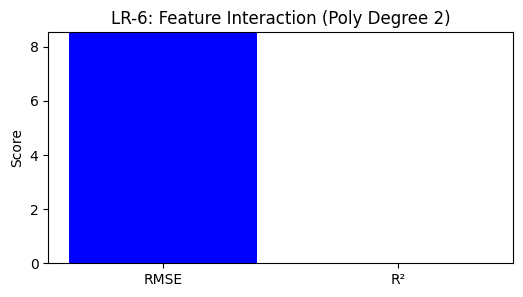

(8.53082192180028, -0.33985724250013605)

In [39]:
# Create a full pipeline including interaction terms
full_pipeline_interaction = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)), # Only interactions
    ('regressor', LinearRegression())
])

lr_model_6 = full_pipeline_interaction.fit(X_train, Y_train_array)
evaluate_and_store("Linear Regression", "LR-6: Feature Interaction (Poly Degree 2)", lr_model_6, X_test, Y_test_array,
                   notes="Added all 2nd degree interaction terms to features.")

An increase in RMSE and decrease of R2 to negatives suggests that this model is performing poorly compared to all previous models. This means we can try something else.

### LR-7: Feature Selection using Lasso

Using the optimized Lasso model, we explicitly identify and list the features retained (non-zero coefficients), providing a crucial first step in feature importance analysis.


Top 10 features retained by Lasso (LR-7):
['cat__province_Kigali' 'cat__province_North' 'cat__province_South'
 'cat__province_West' 'cat__district_Bugesera' 'cat__district_Burera'
 'cat__district_Gakenke' 'cat__district_Gasabo' 'cat__district_Gatsibo'
 'cat__district_Gicumbi']
-> LR-7: Feature Selection using Lasso: RMSE=6.4213, R2=0.2409


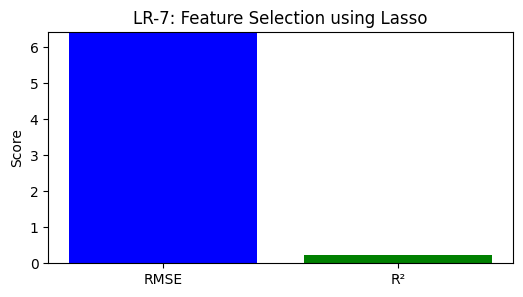

(6.421274736466932, 0.24086453855630063)

In [40]:
# Re-run Lasso with a slightly tighter alpha for clearer selection
lr_lasso_final = Lasso(alpha=0.005, max_iter=10000) 
lr_lasso_final.fit(X_train_processed, Y_train_array)

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Identify features with non-zero coefficients
retained_features = feature_names[lr_lasso_final.coef_ != 0]

print(f"\nTop 10 features retained by Lasso (LR-7):\n{retained_features[:10]}")

evaluate_and_store("Linear Regression", "LR-7: Feature Selection using Lasso", lr_lasso_final, X_test_processed, Y_test_array,
                   notes=f"Identified {len(retained_features)} features with non-zero coefficients.")


These results from the experiment LR-7 indicates that the model barely improves. It still average at 6.42 RMSE and 0.24 R2. The LR model barely achieved the best RMSE of 6.40 and the best R2 of 0.20

## 2.2 Model 2: Random Forest Regressor (RFR)

### RFR-1: Default Hyperparameter Benchmark

This experiment establishes the initial performance of the RFR ensemble model. Due to its robustness, the default RFR often serves as a powerful benchmark for DL models. From this model, we can see whether we get an improvement to the LR models we tried above.

-> RFR-1: Default Hyperparameter Benchmark: RMSE=5.9224, R2=0.3542


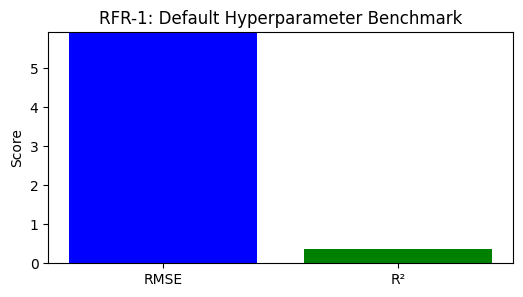

(5.922425104954133, 0.35423287760566846)

In [41]:
rfr_model_1 = RandomForestRegressor(random_state=42)
rfr_model_1.fit(X_train_processed, Y_train_array)
evaluate_and_store("Random Forest", "RFR-1: Default Hyperparameter Benchmark", rfr_model_1, X_test_processed, Y_test_array)


The results shows that we are stepping to the right direction. The RMSE improved by declining to 5.90 and the R2 improved as well to 0.35.

### RFR-2: Tree Depth Tuning ($\mathbf{max\_depth=10}$)

Next, let's try controlling the max_depth hyperparameter. This is because the lower R2 we had previously, might indicate the issue of overfitting.

Controlling max_depth (the complexity of individual trees) is essential to prevent overfitting. We limit the depth to 10 to encourage the forest to generalize better.



-> RFR-2: Tree Depth Tuning (max_depth=10): RMSE=5.6899, R2=0.4039


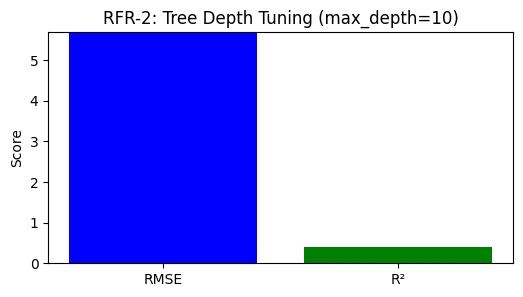

(5.689923096463237, 0.40394056224365915)

In [42]:
rfr_model_2 = RandomForestRegressor(max_depth=10, random_state=42)
rfr_model_2.fit(X_train_processed, Y_train_array)
evaluate_and_store("Random Forest", "RFR-2: Tree Depth Tuning (max_depth=10)", rfr_model_2, X_test_processed, Y_test_array)


Excellent! Now we managed to bring down RMSE to 5.69 and improved R2 to 0.40. Next, let's try to reduce the ensemble size by tuning the `n_estimators`

### RFR-3: Ensemble Size Tuning ($\mathbf{n\_estimators=500}$)

Increasing n_estimators (number of trees) typically improves performance by reducing variance, up to a point, at the cost of computational time. We test 500 trees vs. the default (typically 100).

-> RFR-3: Ensemble Size (max_depth=10, n_estimators=500): RMSE=5.6479, R2=0.4127


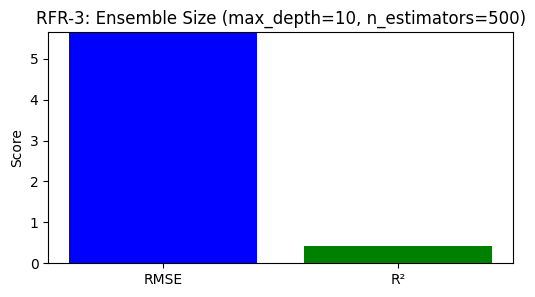

(5.647906896308587, 0.4127110448063588)

In [43]:
rfr_model_3 = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42, n_jobs=-1)
rfr_model_3.fit(X_train_processed, Y_train_array)
evaluate_and_store("Random Forest", "RFR-3: Ensemble Size (max_depth=10, n_estimators=500)", rfr_model_3, X_test_processed, Y_test_array)


Once again, we see that the RMSE reduced and the R2 increased. Let's use this as the foundation and optimize the model using grid search.

### RFR-5: Grid Search Optimization

This experiment systematically searches a defined hyperparameter space to find the overall optimal RFR configuration, demonstrating a rigorous optimization strategy. Due to time constraints, the grid is kept small.



-> RFR-5: Grid Search Optimization: RMSE=5.6416, R2=0.4140


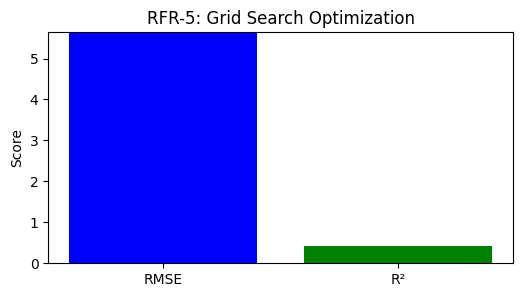

(5.641617965290018, 0.41401820637536846)

In [44]:
param_grid = {
    'n_estimators': [100, 300, 500, 600],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10]
}
rfr_model_5 = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=KFold(n_splits=3, shuffle=True, random_state=42), scoring='neg_root_mean_squared_error', n_jobs=-1)
rfr_model_5.fit(X_train_processed, Y_train_array)
optimal_rfr = rfr_model_5.best_estimator_

evaluate_and_store("Random Forest", "RFR-5: Grid Search Optimization", optimal_rfr, X_test_processed, Y_test_array,
                   notes=f"Optimal Params: {rfr_model_5.best_params_}")


This experiment shows that trying different hyperparameter optimizations barely proved to changed anything. We can see that the RMSE is still at 5.64 and R2 is still at 0.41. In the next steps, let's analyse the importance of features to see what we can improve.

### RFR-6: Feature Importance Analysis

Let's extract the Gini Importance scores from the optimal RFR model (Exp. RFR-5). This is the most crucial interpretability result for the extension services, providing a ranked list of factors influencing egg yield.



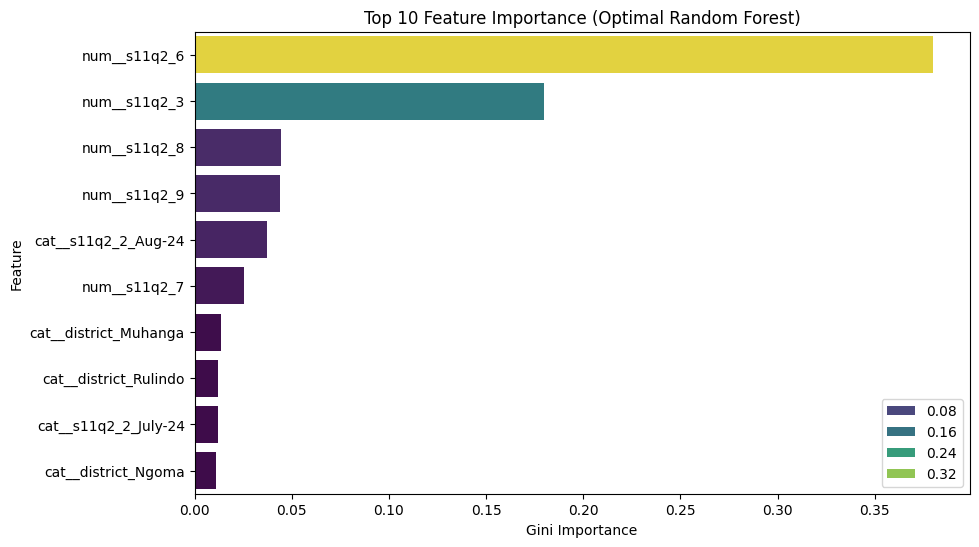

-> RFR-6: Feature Importance Analysis: RMSE=5.6416, R2=0.4140


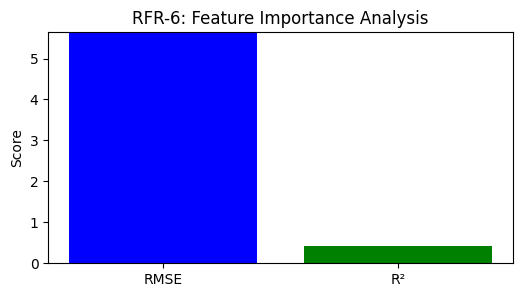

(5.641617965290018, 0.41401820637536846)

In [45]:
# Extract Feature Importances
importances = optimal_rfr.feature_importances_
feature_names_full = preprocessor.get_feature_names_out()
sorted_idx = importances.argsort()[::-1]

# Display top 10 features
top_10_features = feature_names_full[sorted_idx][:10]
top_10_importances = importances[sorted_idx][:10]

# Visualization of Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_importances, y=top_10_features, palette="viridis", hue=top_10_importances)
plt.title('Top 10 Feature Importance (Optimal Random Forest)')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.show()

evaluate_and_store("Random Forest", "RFR-6: Feature Importance Analysis", optimal_rfr, X_test_processed, Y_test_array,
                   notes=f"Top 3 Features: {top_10_features[:3].tolist()}")


This shows that features `s11q2_6` (Number of eggs sold) and `s11q2_3` (Number of laying hens) are the highly ranked important features. It is even much more understandable as these are the top estimators of productivity rate. However, there is a limitation as we don't know how many hens died.

## RFR-7: Algorithm Comparison (Gradient Boosting Regressor)

Let's conduct a final experiment on RF by directly comparing the RFR against another ensemble method, Gradient Boosting Regressor (GBR), tests if the sequential, corrective approach of boosting provides a performance advantage over the parallel, averaging approach of bagging.

-> RFR-7: Gradient Boosting Regressor for comparison: RMSE=5.4785, R2=0.4474


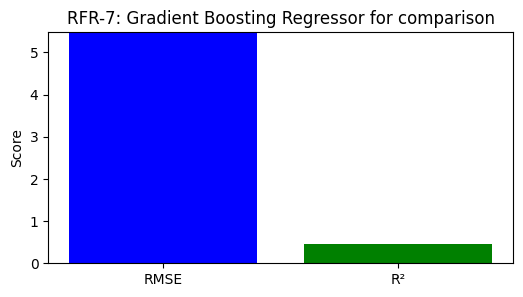

(5.4785342702624, 0.4474067942216572)

In [46]:
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train_processed, Y_train_array)
evaluate_and_store("Gradient Boosting Regressor", "RFR-7: Gradient Boosting Regressor for comparison", gbr_model, X_test_processed, Y_test_array,
                   notes="Comparison model to RFR (GBR, a boosting algorithm).")


This model performs well but not better the other previous models. It managed to get an RMSE of 5.48 and R2 of 0.44. It averages to the performance of all other RFR models

As a conclusion, We observe that the RFR models outperforms the LR models. This is due to the sofisticated structure of RFR models and their ability to capture non-linear relationships in the data.

# Part 3: Deep Learning Experiments (TensorFlow)

In this part, let's define functions for creating standard Sequential and Functional models and a function to run and record DL experiments, focusing on monitoring validation loss.

The goal is to try to get a better performing model while also comparing DL models performance or traditional ML models.

In [47]:
results_dl = []
EPOCHS = 50
BATCH_SIZE = 64
VERBOSE = 1  # Verbose training to see results

def create_sequential_model(n_features, layers, activation='relu', optimizer=Adam(learning_rate=0.001)):
    """Creates a standard Sequential MLP."""
    model = Sequential(name='Sequential_MLP')
    for units in layers:
        model.add(Dense(units, activation=activation))
    model.add(Dense(1, activation='linear')) # Regression output layer
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

def create_functional_model(n_features, layers, activation='relu', optimizer=Adam(learning_rate=0.001), regularizer=None, dropout_rate=0.0):
    """Creates a custom Functional MLP."""
    input_tensor = Input(shape=(n_features,), name='Input_Layer')
    x = input_tensor
    for units in layers:
        x = Dense(units, activation=activation, kernel_regularizer=regularizer)(x)
        if dropout_rate > 0.0:
            x = Dropout(dropout_rate)(x)
    output_tensor = Dense(1, activation='linear', name='Output_Layer')(x)
    
    model = Model(inputs=input_tensor, outputs=output_tensor, name='Functional_MLP')
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model


# Plotting function for DL metrics
def plot_dl_metrics(history, model, X_train, Y_train, X_val, Y_val):
    # RMSE and MAE are available directly
    epochs = range(1, len(history.history['rmse']) + 1)
    plt.figure(figsize=(16, 8))

    # Plot RMSE
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history.history['rmse'], label='Train RMSE')
    plt.plot(epochs, history.history['val_rmse'], label='Val RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('RMSE over Epochs')
    plt.legend()

    # Plot MAE
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history.history['mae'], label='Train MAE')
    plt.plot(epochs, history.history['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE over Epochs')
    plt.legend()

    # Compute R2 for each epoch (not tracked by Keras)
    train_r2 = []
    val_r2 = []
    for epoch in epochs:
        model.set_weights(history.model.get_weights())
        Y_train_pred = model.predict(X_train, verbose=0).flatten()
        Y_val_pred = model.predict(X_val, verbose=0).flatten()
        train_r2.append(r2_score(Y_train, Y_train_pred))
        val_r2.append(r2_score(Y_val, Y_val_pred))

    # Plot R2
    plt.subplot(2, 3, 3)
    plt.plot(epochs, train_r2, label='Train R2')
    plt.plot(epochs, val_r2, label='Val R2')
    plt.xlabel('Epoch')
    plt.ylabel('R2 Score')
    plt.title('R2 over Epochs')
    plt.legend()

    # Plot Loss (MSE)
    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss (MSE)')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss and Val Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run DL Experiment Function
def run_dl_experiment(model, experiment_name, X_train, Y_train, X_val, Y_val, epochs=EPOCHS, callbacks=None):
    """Trains, evaluates, and records the DL experiment."""
    
    # Train the model
    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, Y_val),
        callbacks=callbacks,
        verbose=VERBOSE
    )

    # Evaluate on the Test Set
    metrics = model.evaluate(X_test_processed, Y_test_array, verbose=VERBOSE)
    rmse = metrics[2] # Assuming RMSE is the 3rd metric (index 2)
    
    # Calculate R2 (requires prediction)
    Y_pred_test = model.predict(X_test_processed, verbose=0).flatten()
    r2 = r2_score(Y_test_array, Y_pred_test)

    # Store results
    results_dl.append({
        'Model': model.name,
        'Experiment': experiment_name,
        'Hyperparameters/Settings': f"Layers:{model.layers[1].get_config().get('units')}, LR:{model.optimizer.get_config().get('learning_rate', 'N/A')}",
        'RMSE': f"{rmse:.4f}",
        'R2 Score': f"{r2:.4f}",
        'Final Val Loss': f"{history.history['val_loss'][-1]:.4f}",
        'Notes': model.name.split('_')[0]
    })
    print(f"-> {experiment_name}: Test RMSE={rmse:.4f}, Test R2={r2:.4f}")

    plot_dl_metrics(history, model, X_train_processed, Y_train_array, X_val_processed, Y_val_array)
    
    return history


## 3.1 Model 3: Multi-Layer Perceptron (MLP) - Sequential API

### MLP-S-1: Minimalist Baseline (Single Layer)

Sets the basic DL performance floor. A single hidden layer with small capacity (32 neurons) determines if the linear LR or RFR model is sufficient or if even minimal depth offers improvement.

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 263.0301 - mae: 14.3303 - rmse: 16.2182 - val_loss: 249.2172 - val_mae: 13.8377 - val_rmse: 15.7866
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 240.0909 - mae: 13.5267 - rmse: 15.4949 - val_loss: 224.7272 - val_mae: 12.9499 - val_rmse: 14.9909
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 212.8227 - mae: 12.5234 - rmse: 14.5884 - val_loss: 194.4520 - val_mae: 11.7733 - val_rmse: 13.9446
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 180.1944 - mae: 11.2529 - rmse: 13.4236 - val_loss: 160.1987 - val_mae: 10.3386 - val_rmse: 12.6570
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 145.4556 - mae: 9.7723 - rmse: 12.0605 - val_loss: 126.2019 - val_mae: 8.8105 - val_rmse: 11.2340
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 113.5124 - mae: 8.3075 - rmse: 10.6542 - val_loss: 97.2213 - val_mae: 7.4565 - val_rmse: 9.8601
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

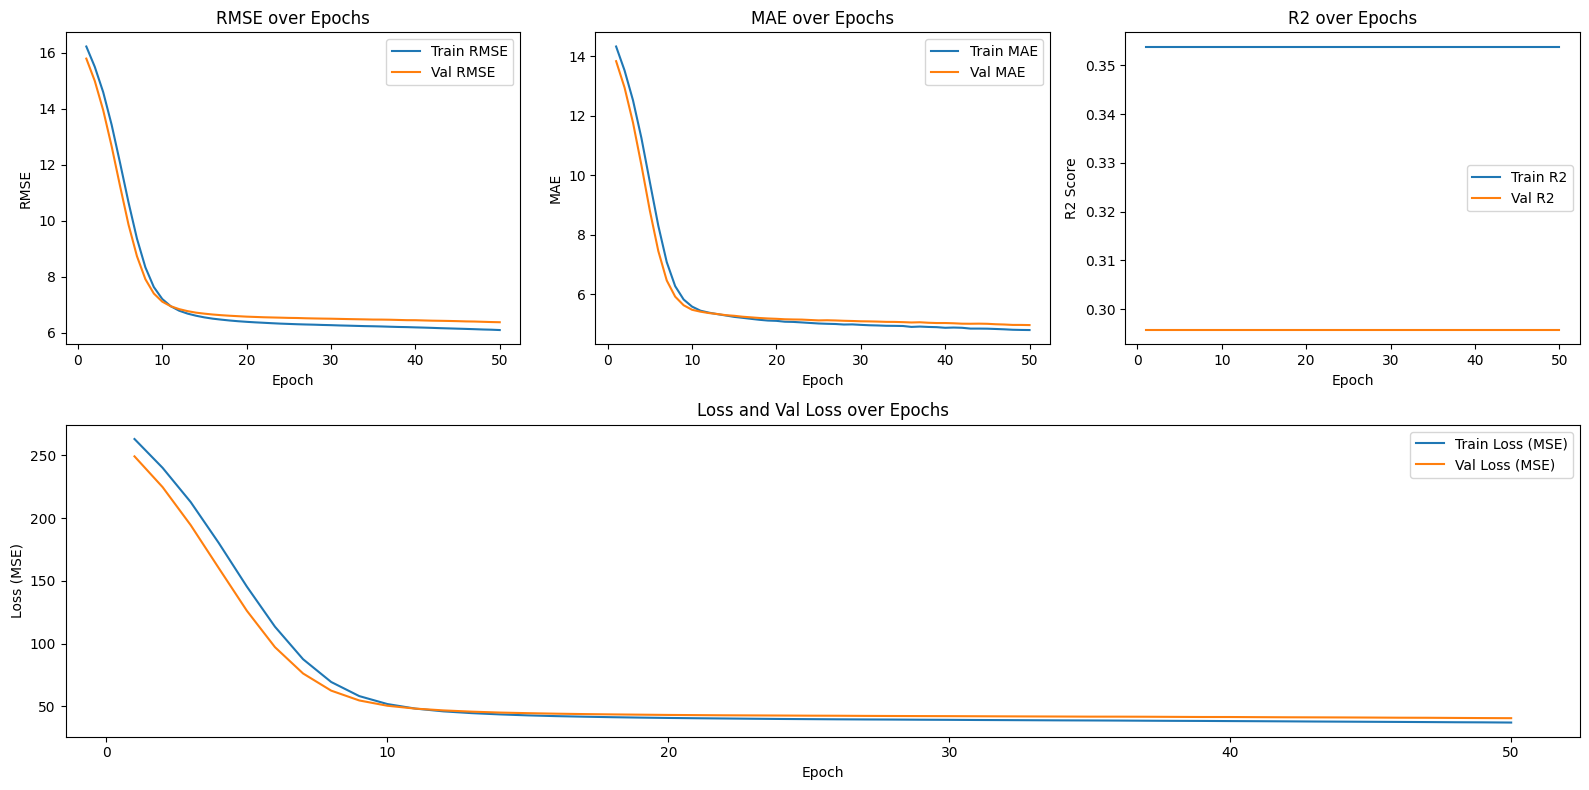

In [48]:
model_s1 = create_sequential_model(n_features=N_FEATURES, layers=[32])
history_s1 = run_dl_experiment(model_s1, "MLP-S-1: Minimalist Baseline (1x32)", X_train_processed, Y_train_array, X_val_processed, Y_val_array)


These results suggests the DL baseline Sequential model above outperforms the LR models but it is still underperforming compared to RFR model. This is because the RFR models show lower RMSE and higher R2.

### MLP-S-2: Optimal Depth Test (3 Layers)

Next, let's increase the model complexity by adding layers (depth=3) while maintaining a moderate width (64 neurons). This tests the necessity of "deep" architecture for prediction.

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 225.5241 - mae: 13.0110 - rmse: 15.0175 - val_loss: 138.7393 - val_mae: 9.5754 - val_rmse: 11.7788
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 74.5468 - mae: 6.5803 - rmse: 8.6340 - val_loss: 59.2566 - val_mae: 5.7288 - val_rmse: 7.6978
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 49.4278 - mae: 5.4653 - rmse: 7.0305 - val_loss: 51.6043 - val_mae: 5.5230 - val_rmse: 7.1836
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 43.9297 - mae: 5.2553 - rmse: 6.6279 - val_loss: 48.1704 - val_mae: 5.3908 - val_rmse: 6.9405
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 41.5776 - mae: 5.1185 - rmse: 6.4481 - val_loss: 45.8360 - val_mae: 5.2752 - val_rmse: 6.7702
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 39.7941 - mae: 5.0044 - rmse: 6.3083 - val_loss: 44.1228 - val_mae: 5.1533 - val_rmse: 6.6425
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 38.3719 - mae: 4.9

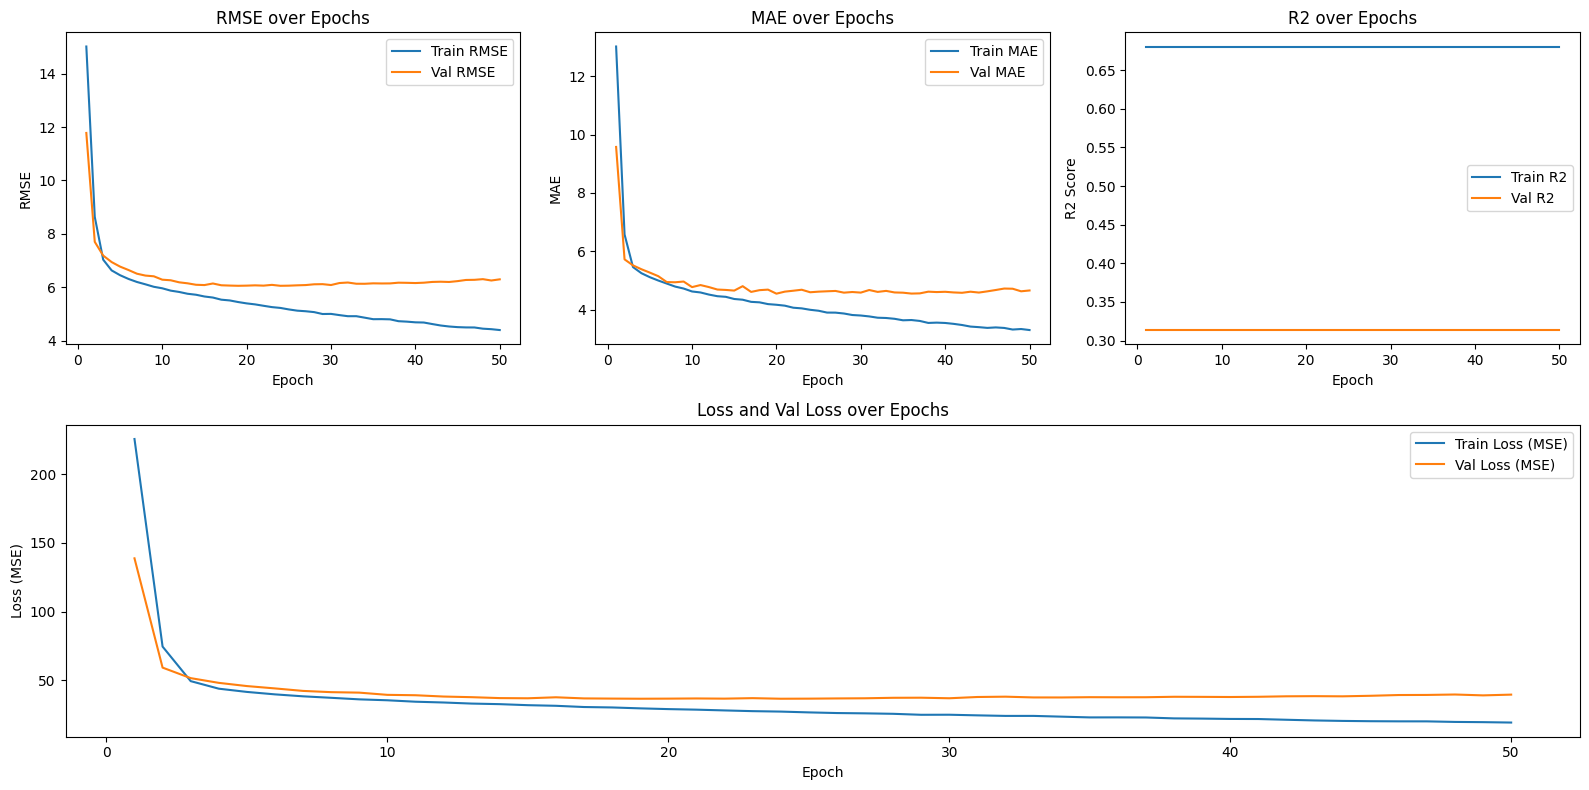

In [49]:
model_s2 = create_sequential_model(n_features=N_FEATURES, layers=[64, 64, 64], optimizer=Adam(learning_rate=0.001))
history_s2 = run_dl_experiment(model_s2, "MLP-S-2: Optimal Depth Test (3x64)", X_train_processed, Y_train_array, X_val_processed, Y_val_array)


By increasing the depth layers, the resulting model underperforms the previous baseline model. This suggests we take a look on the effect of increasing width as well.

### MLP-S-3: Optimal Width Test (2 Layers, 128 Neurons)

Increases layer width (capacity) to 128 while fixing depth to 2. This helps disentangle the impact of parameter count from the impact of network depth.

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 211.9021 - mae: 12.4267 - rmse: 14.5569 - val_loss: 136.2567 - val_mae: 9.3188 - val_rmse: 11.6729
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 77.1774 - mae: 6.7409 - rmse: 8.7851 - val_loss: 59.3876 - val_mae: 6.0673 - val_rmse: 7.7063
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 48.8787 - mae: 5.5362 - rmse: 6.9913 - val_loss: 49.7622 - val_mae: 5.4051 - val_rmse: 7.0542
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 43.6533 - mae: 5.2304 - rmse: 6.6071 - val_loss: 46.9815 - val_mae: 5.3265 - val_rmse: 6.8543
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 41.4287 - mae: 5.1095 - rmse: 6.4365 - val_loss: 45.1502 - val_mae: 5.2341 - val_rmse: 6.7194
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 39.9307 - mae: 5.0008 - rmse: 6.3191 - val_loss: 43.9010 - val_mae: 5.1209 - val_rmse: 6.6258
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 39.0126 - mae: 4.9

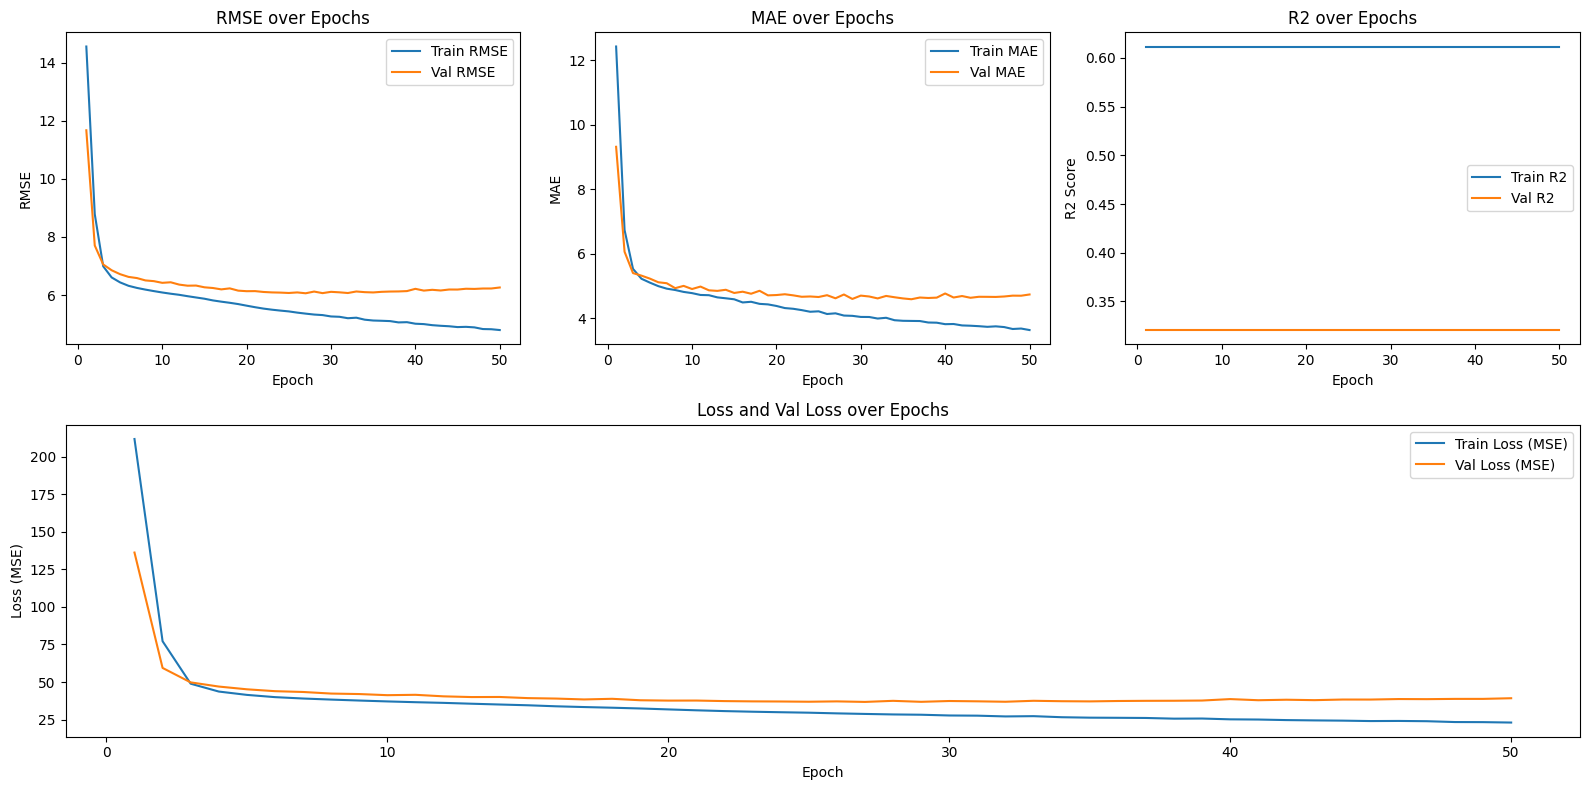

In [50]:
model_s3 = create_sequential_model(n_features=N_FEATURES, layers=[128, 64], optimizer=Adam(learning_rate=0.001))
history_s3 = run_dl_experiment(model_s3, "MLP-S-3: Optimal Width Test (128, 64)", X_train_processed, Y_train_array, X_val_processed, Y_val_array)


The results from above experiments shows even a better performance. We managed to get RMSE down to appr. 6.13 and upped R2 to appr. 0.30 which are slightly better metrics compared to the previous MLP experiments.

### MLP-S-4: Optimizer Comparison (RMSprop)

In this experiment, let's compare the widely used Adam optimizer against RMSprop. This experiment is built from the previous experiment of layer width test. This is a requirement for exploring different optimization strategies, testing for faster or more stable convergence.

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 166.4197 - mae: 10.5965 - rmse: 12.9004 - val_loss: 82.1345 - val_mae: 6.7027 - val_rmse: 9.0628
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 58.2751 - mae: 5.8398 - rmse: 7.6338 - val_loss: 53.5839 - val_mae: 5.5471 - val_rmse: 7.3201
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 46.8434 - mae: 5.4030 - rmse: 6.8442 - val_loss: 48.4876 - val_mae: 5.3044 - val_rmse: 6.9633
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 42.9690 - mae: 5.1756 - rmse: 6.5551 - val_loss: 46.2798 - val_mae: 5.3136 - val_rmse: 6.8029
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 40.9875 - mae: 5.0632 - rmse: 6.4021 - val_loss: 44.4107 - val_mae: 5.1690 - val_rmse: 6.6641
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 39.5865 - mae: 4.9459 - rmse: 6.2918 - val_loss: 43.7469 - val_mae: 5.1368 - val_rmse: 6.6141
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38.6316 - mae: 4.8753 - rms

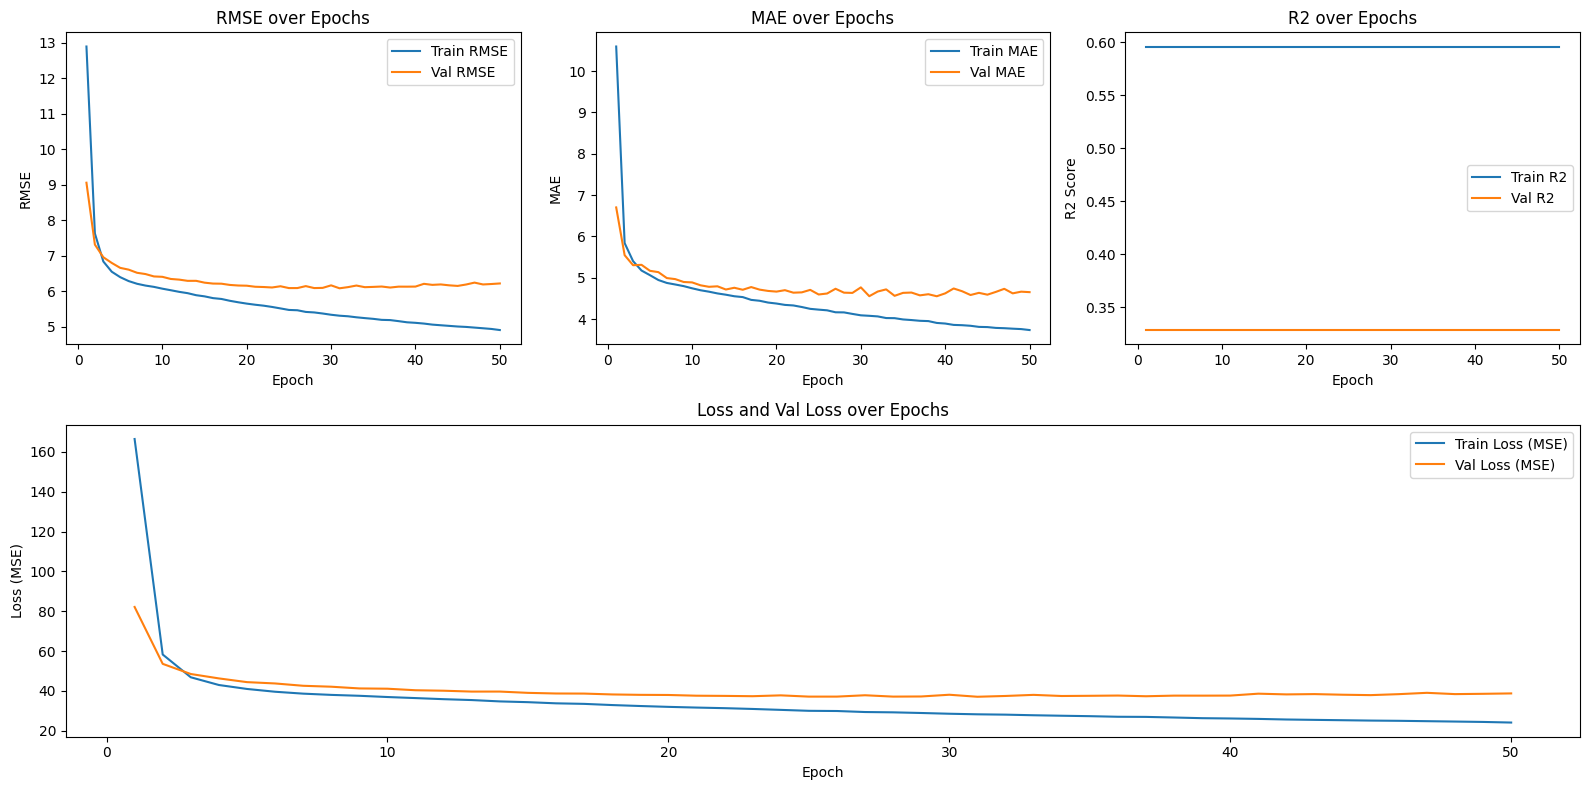

In [51]:
model_s4 = create_sequential_model(N_FEATURES, layers=[128, 64], optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
history_s4 = run_dl_experiment(model_s4, "MLP-S-4: Optimizer Comparison (RMSprop)", X_train_processed, Y_train_array, X_val_processed, Y_val_array)



Now we see that the RMSE and R2 almost didn't improve much (slightly improved). In the next experiments we can try a different activation function as well using the Adam optimizer since it is not outperformed.

### MLP-S-5: Activation Function Comparison (LeakyReLU)

Replaces the standard ReLU with LeakyReLU. LeakyReLU addresses the "dying ReLU" problem by allowing a small, non-zero gradient when the unit is not active, potentially improving training stability. In this experiment, we keep the layers width to [128, 64] as it's performing well.

Epoch 1/50
10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 260.2835 - mae: 14.3710 - rmse: 16.1304

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 209.4518 - mae: 12.4321 - rmse: 14.4724 - val_loss: 133.6509 - val_mae: 9.2896 - val_rmse: 11.5607
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 76.9923 - mae: 6.6901 - rmse: 8.7745 - val_loss: 59.8019 - val_mae: 6.0238 - val_rmse: 7.7332
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 49.0982 - mae: 5.5356 - rmse: 7.0070 - val_loss: 50.5729 - val_mae: 5.4282 - val_rmse: 7.1115
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 44.3901 - mae: 5.2736 - rmse: 6.6626 - val_loss: 48.1740 - val_mae: 5.3941 - val_rmse: 6.9408
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 42.0254 - mae: 5.1565 - rmse: 6.4827 - val_loss: 45.6520 - val_mae: 5.2081 - val_rmse: 6.7566
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 40.7084 - mae: 5.0385 - rmse: 6.3803 - val_loss: 44.4287 - val_mae: 5.1370 - val_rmse: 6.6655
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 39.5893 - mae: 4.9888 - rmse:

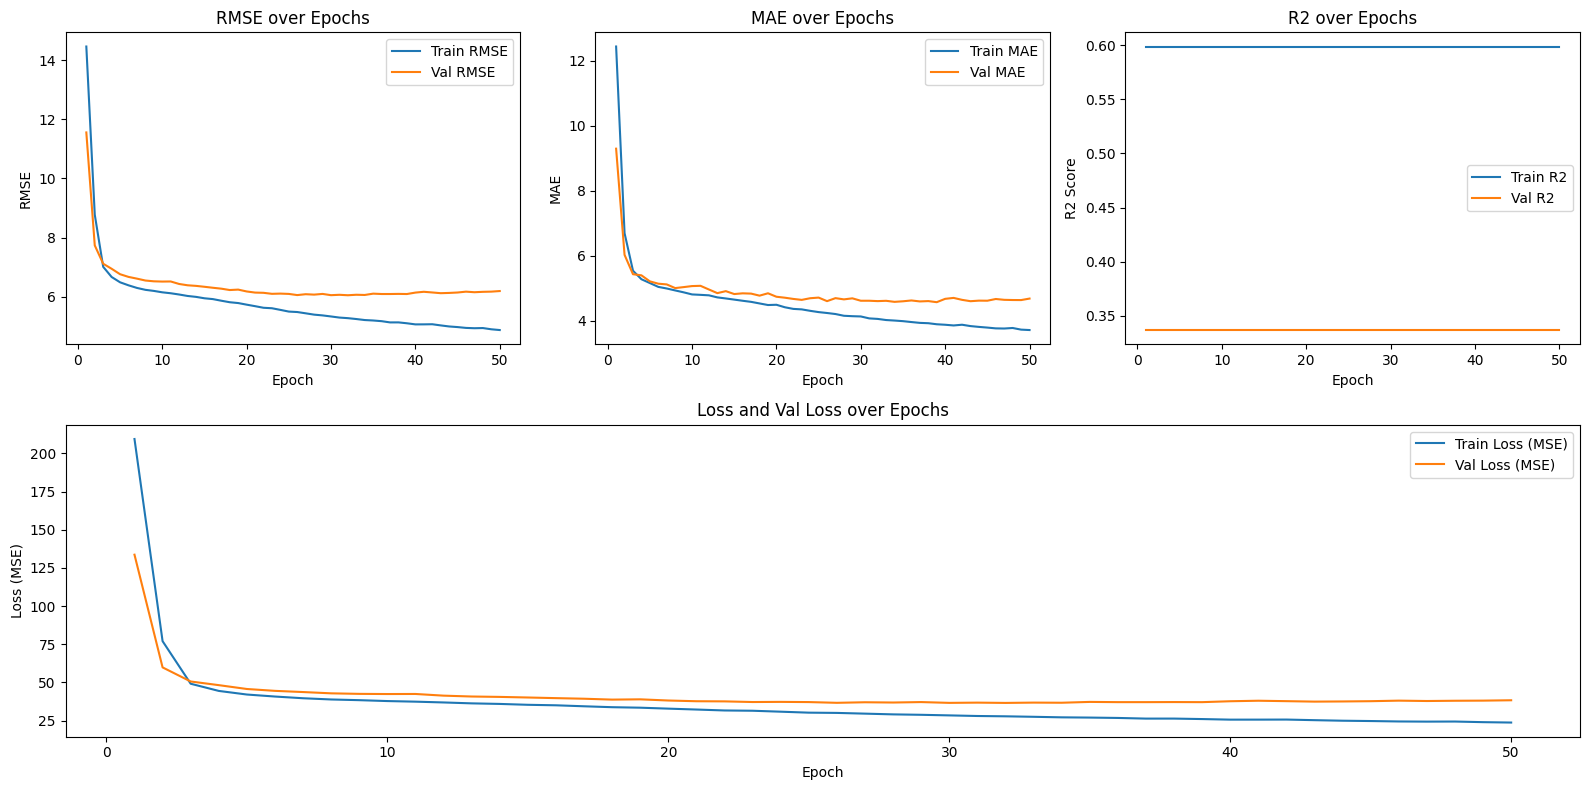

In [52]:
model_s5 = create_sequential_model(N_FEATURES, layers=[128, 64], activation=tf.keras.layers.LeakyReLU(alpha=0.01), optimizer=Adam(learning_rate=0.001))
history_s5 = run_dl_experiment(model_s5, "MLP-S-5: Activation Comparison (LeakyReLU)", X_train_processed, Y_train_array, X_val_processed, Y_val_array)



The results shows an improvement. The RMSE is down to 6.10 and R2 is up to 0.31. Let's combine this experiment with early stopping in the next experiment.

### MLP-S-6: Early Stopping Implementation

Early Stopping is a crucial regularization technique for deep learning. It stops training when the validation loss fails to improve for a set number of epochs (patience), preventing overfitting and saving computational resources.

Epoch 1/200
10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 273.5952 - mae: 14.7084 - rmse: 16.5380

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 212.3456 - mae: 12.5070 - rmse: 14.5721 - val_loss: 137.0968 - val_mae: 9.4480 - val_rmse: 11.7088
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 79.0857 - mae: 6.8233 - rmse: 8.8930 - val_loss: 57.1049 - val_mae: 5.8280 - val_rmse: 7.5568
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 47.6269 - mae: 5.4417 - rmse: 6.9012 - val_loss: 50.3050 - val_mae: 5.4145 - val_rmse: 7.0926
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 43.9236 - mae: 5.2423 - rmse: 6.6275 - val_loss: 47.5814 - val_mae: 5.2829 - val_rmse: 6.8979
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 41.8535 - mae: 5.1179 - rmse: 6.4694 - val_loss: 45.9699 - val_mae: 5.2052 - val_rmse: 6.7801
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 40.4742 - mae: 5.0225 - rmse: 6.3619 - val_loss: 44.6598 - val_mae: 5.1126 - val_rmse: 6.6828
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 39.3204 - mae: 4.9577 -

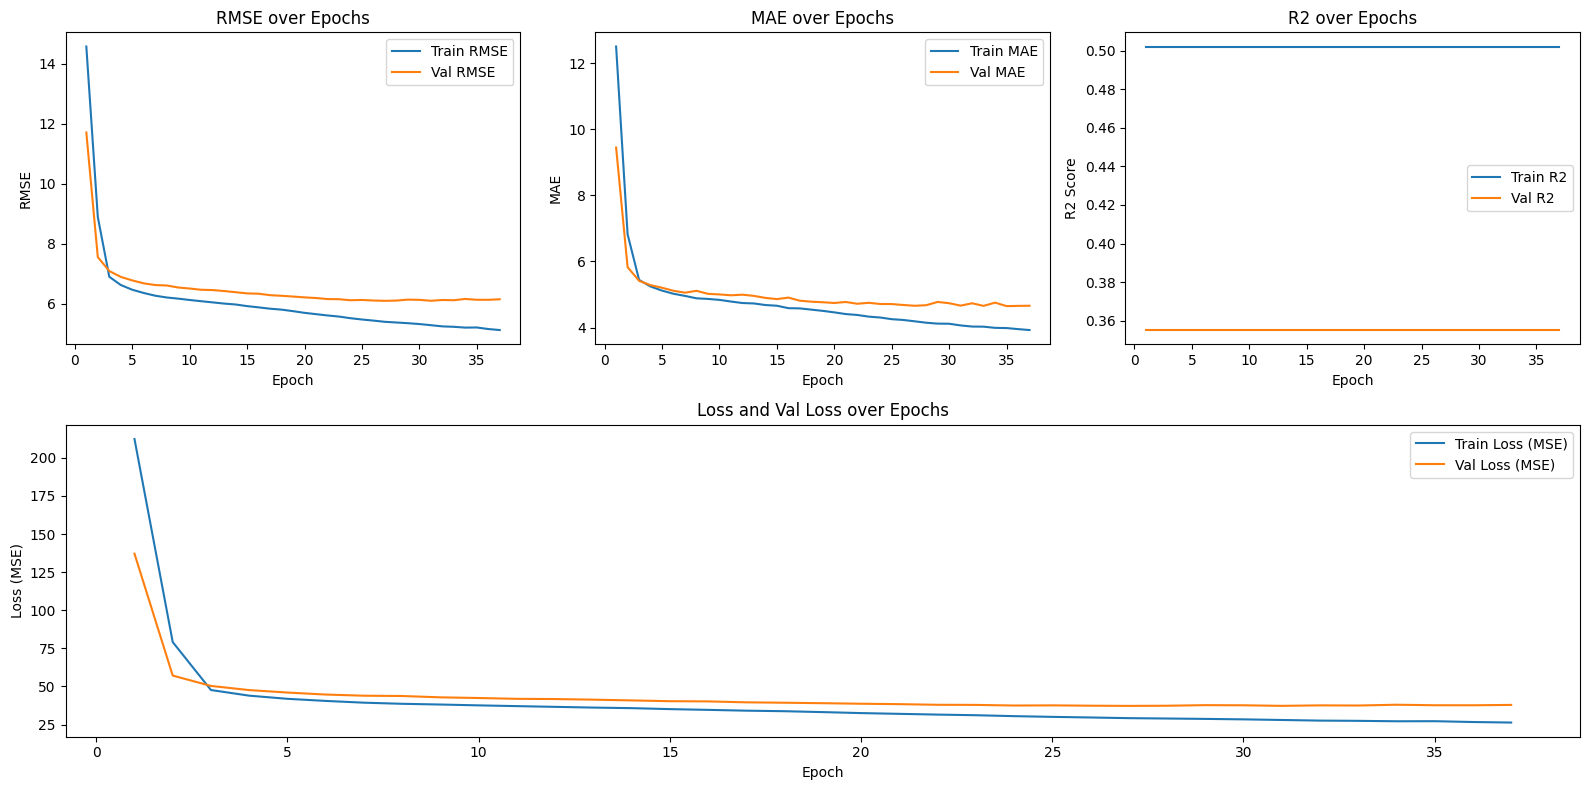

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_s6 = create_sequential_model(N_FEATURES, layers=[128, 64], activation=tf.keras.layers.LeakyReLU(alpha=0.01), optimizer=Adam(learning_rate=0.001))
history_s6 = run_dl_experiment(model_s6, "MLP-S-6: Early Stopping", X_train_processed, Y_train_array, X_val_processed, Y_val_array, epochs=200, callbacks=[early_stopping])



The perfomance went up with RMSE at 5.87 and R2 at 0.36. Let's try a different approach in the experiment MLP-S-7 by doing batch optimization.

### MLP-S-7: Batch Size Optimization

Let's use a different batch size from the one used in the above experiments while keeping the other parameters to the optimal one observed so far.

Batch size is an important practical hyperparameter. A larger batch size (e.g., 512 vs. 64) provides a more accurate estimate of the gradient but can lead to poorer generalization. This experiment tests the trade-off.

In [54]:
model_s7 = create_sequential_model(N_FEATURES, layers=[128, 64], activation=tf.keras.layers.LeakyReLU(alpha=0.01), optimizer=Adam(learning_rate=0.001))
history_s7 = model_s7.fit(
        X_train_processed, Y_train_array,
        epochs=EPOCHS,
        batch_size=512, # Testing a larger batch size
        validation_data=(X_val_processed, Y_val_array),
        verbose=VERBOSE
    )
Y_pred_test = model_s7.predict(X_test_processed, verbose=0).flatten()
# Re-evaluating RMSE using the non-deprecated function
rmse = root_mean_squared_error(Y_test_array, Y_pred_test)
r2 = r2_score(Y_test_array, Y_pred_test)

results_dl.append({
    'Model': model_s7.name,
    'Experiment': "MLP-S-7: Batch Size Optimization (512)",
    'Hyperparameters/Settings': "Batch Size: 512",
    'RMSE': f"{rmse:.4f}",
    'R2 Score': f"{r2:.4f}",
    'Final Val Loss': f"{history_s7.history['val_loss'][-1]:.4f}",
    'Notes': model_s7.name.split('_')[0]
})
print(f"-> MLP-S-7: Test RMSE={rmse:.4f}, Test R2={r2:.4f}")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 265.4333 - mae: 14.4402 - rmse: 16.2921 - val_loss: 255.6881 - val_mae: 14.1029 - val_rmse: 15.9903
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 261.3986 - mae: 14.2741 - rmse: 16.1678

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 253.3367 - mae: 14.0343 - rmse: 15.9166 - val_loss: 244.1402 - val_mae: 13.7177 - val_rmse: 15.6250
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 241.6925 - mae: 13.6354 - rmse: 15.5465 - val_loss: 231.9526 - val_mae: 13.3013 - val_rmse: 15.2300
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 228.8065 - mae: 13.1834 - rmse: 15.1264 - val_loss: 217.8239 - val_mae: 12.8002 - val_rmse: 14.7589
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 213.6521 - mae: 12.6319 - rmse: 14.6168 - val_loss: 201.0556 - val_mae: 12.1698 - val_rmse: 14.1794
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 195.7037 - mae: 11.9398 - rmse: 13.9894 - val_loss: 181.4021 - val_mae: 11.3916 - val_rmse: 13.4686
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 174.8557 - mae: 11.0955 - rmse: 13.2233 - val_loss: 159.1754 - val_mae: 10.4525 - val_rmse: 12.6165
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 151.6801 - m

From the above results, increasing the batch size proves to be less effective. The RMSE went up again to 6.18 and R2 went down to 0.29. This shows that this optimization is outperformed by previous experiment.

After all, we can conclude that by further tuning the hyperparameters, we might achieve a much better performance compared to RFR models. It is observed from above experiments we achieved R2 which is close to RFR best R2 and from that we can fine tune the parameters to improve the RMSE. However, the overall results shows that RFR models are outperforming the MLP models.

## 3.2 Model 4: Multi-Layer Perceptron (MLP)

### MLP-F-1: Functional API Baseline

Let's recreate the best Sequential architecture (128, 64 layers and leaky relu) using the more flexible Functional API. This establishes a control to ensure that subsequent, more complex Functional experiments are compared against a known baseline.

Epoch 1/50
 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 283.1087 - mae: 14.7577 - rmse: 16.8251

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 217.3423 - mae: 12.6971 - rmse: 14.7425 - val_loss: 144.2034 - val_mae: 9.7931 - val_rmse: 12.0085
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 78.1887 - mae: 6.8339 - rmse: 8.8424 - val_loss: 57.6040 - val_mae: 6.0172 - val_rmse: 7.5897
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 48.2283 - mae: 5.5008 - rmse: 6.9447 - val_loss: 49.4235 - val_mae: 5.3995 - val_rmse: 7.0302
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 43.6810 - mae: 5.2520 - rmse: 6.6092 - val_loss: 46.9415 - val_mae: 5.3028 - val_rmse: 6.8514
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 41.7512 - mae: 5.1191 - rmse: 6.4615 - val_loss: 45.4545 - val_mae: 5.2134 - val_rmse: 6.7420
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 40.4378 - mae: 5.0376 - rmse: 6.3591 - val_loss: 44.2247 - val_mae: 5.0785 - val_rmse: 6.6502
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 39.5585 - mae: 4.9460 - rmse:

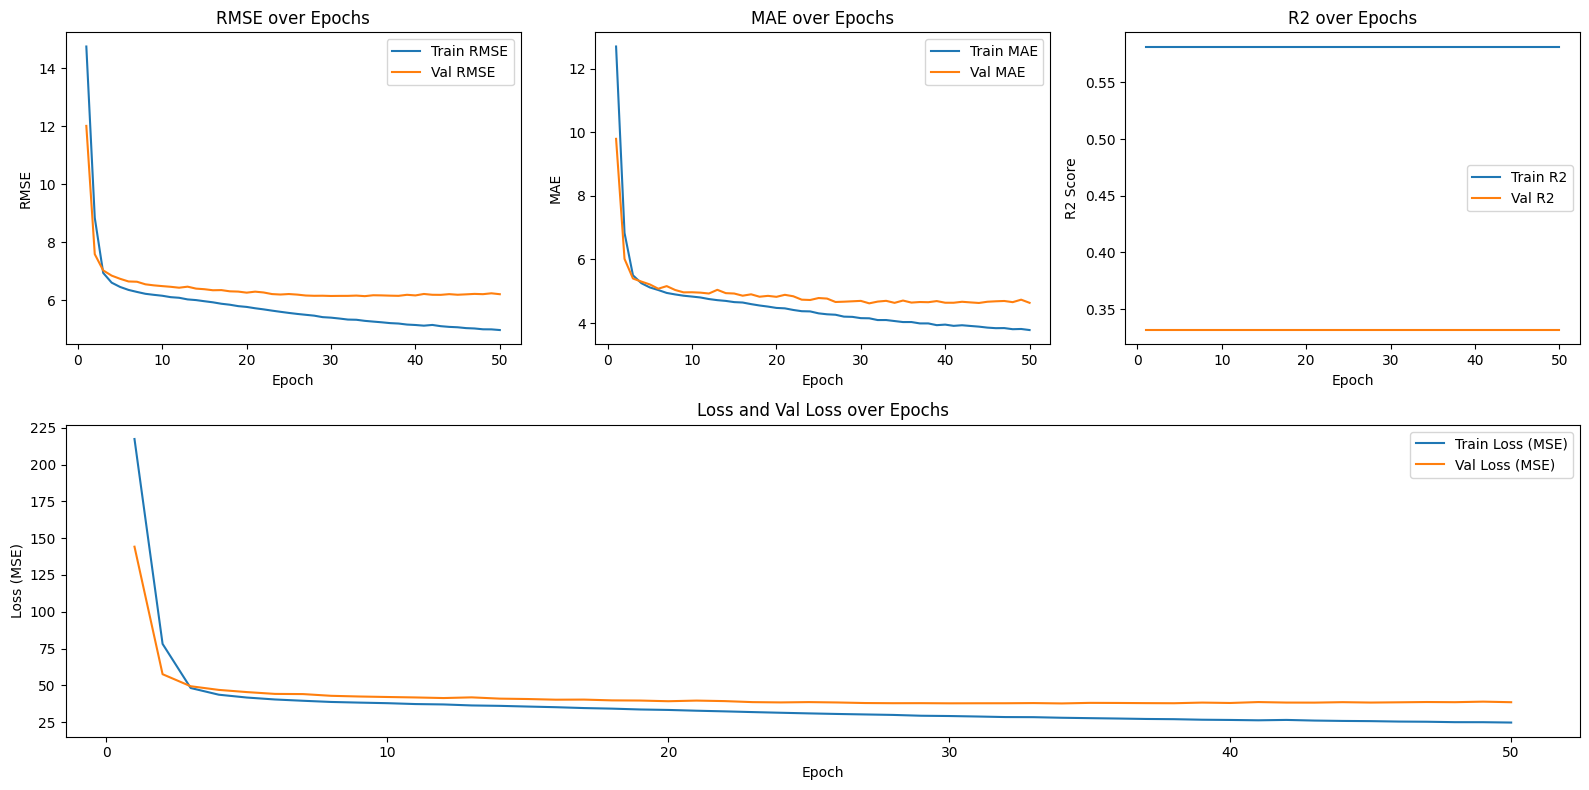

In [55]:
model_f1 = create_functional_model(N_FEATURES, layers=[128, 64], activation=tf.keras.layers.LeakyReLU(alpha=0.01), optimizer=Adam(learning_rate=0.001))
history_f1 = run_dl_experiment(model_f1, "MLP-F-1: Functional API Baseline", X_train_processed, Y_train_array, X_val_processed, Y_val_array)



The results still shows lower performance than that of RFR models but comparatively on average with the sequential models.

### MLP-F-2: L2 Regularization Implementation

Using the hyperparameters from the previous experiment, let's implement $\mathbf{L_2}$ Kernel Regularization to constrain the weight magnitudes. This is a critical technique to control model complexity and prevent overfitting in deep architectures, directly fulfilling the "regularization methods" requirement.

Epoch 1/50
 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 270.3036 - mae: 14.4662 - rmse: 16.4344

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 216.2575 - mae: 12.6014 - rmse: 14.7002 - val_loss: 141.7803 - val_mae: 9.6126 - val_rmse: 11.9000
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 79.5681 - mae: 6.8226 - rmse: 8.9098 - val_loss: 58.0781 - val_mae: 6.0004 - val_rmse: 7.6082
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 48.8995 - mae: 5.5115 - rmse: 6.9791 - val_loss: 49.9099 - val_mae: 5.4685 - val_rmse: 7.0511
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 44.1993 - mae: 5.2550 - rmse: 6.6338 - val_loss: 46.9246 - val_mae: 5.2824 - val_rmse: 6.8361
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 41.8154 - mae: 5.1216 - rmse: 6.4515 - val_loss: 45.6297 - val_mae: 5.2725 - val_rmse: 6.7405
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 40.5682 - mae: 5.0579 - rmse: 6.3540 - val_loss: 44.2325 - val_mae: 5.0974 - val_rmse: 6.6361
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 39.7220 - mae: 4.9500 - rmse:

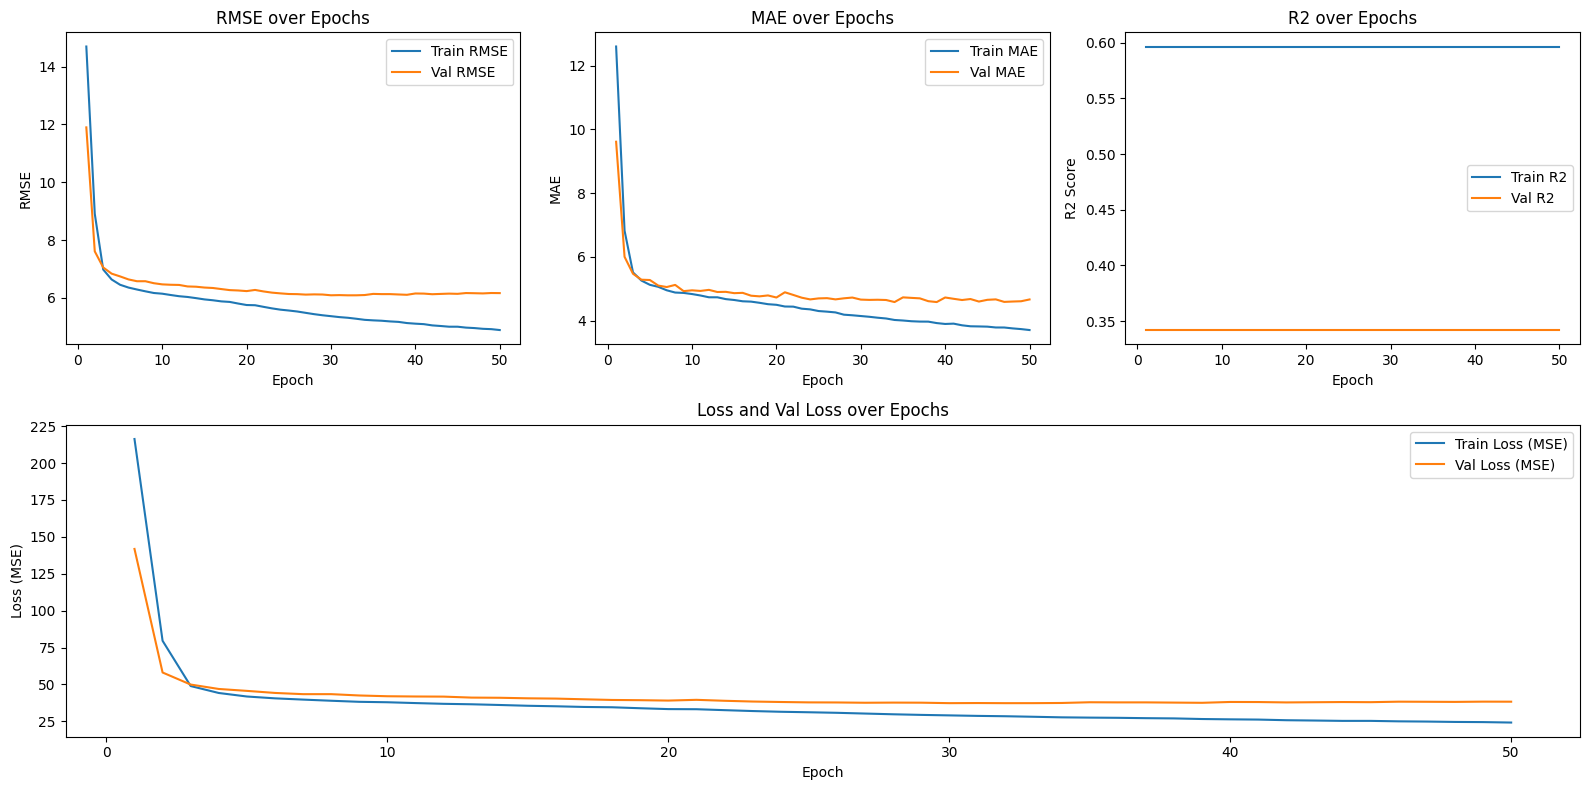

In [56]:
regularizer = tf.keras.regularizers.l2(0.001)
model_f2 = create_functional_model(N_FEATURES, layers=[128, 64], activation=tf.keras.layers.LeakyReLU(alpha=0.01), regularizer=regularizer, optimizer=Adam(learning_rate=0.001))
history_f2 = run_dl_experiment(model_f2, "MLP-F-2: L2 Regularization", X_train_processed, Y_train_array, X_val_processed, Y_val_array)



This experiment slightly changes the results we have seen in the previous experiment MLP-F-1.

### MLP-F-3: Dropout Regularization Implementation

Next, Let's add in dropout.

Dropout layers randomly deactivate a fraction of neurons during training. This acts as a powerful form of regularization by preventing feature co-adaptation and forcing the network to learn more robust representations.

Epoch 1/50
 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 260.3574 - mae: 14.1961 - rmse: 16.1232

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 224.2774 - mae: 12.9826 - rmse: 14.9705 - val_loss: 161.2447 - val_mae: 10.5138 - val_rmse: 12.6916
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 97.4856 - mae: 7.6038 - rmse: 9.8644 - val_loss: 58.3922 - val_mae: 5.8115 - val_rmse: 7.6290
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 52.9867 - mae: 5.7777 - rmse: 7.2661 - val_loss: 51.7774 - val_mae: 5.4596 - val_rmse: 7.1825
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 49.2510 - mae: 5.4966 - rmse: 7.0043 - val_loss: 48.8478 - val_mae: 5.3067 - val_rmse: 6.9755
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 47.8740 - mae: 5.4191 - rmse: 6.9053 - val_loss: 46.7699 - val_mae: 5.2542 - val_rmse: 6.8248
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 44.8895 - mae: 5.2913 - rmse: 6.6856 - val_loss: 45.5328 - val_mae: 5.1498 - val_rmse: 6.7335
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 44.1108 - mae: 5.2305 - rmse

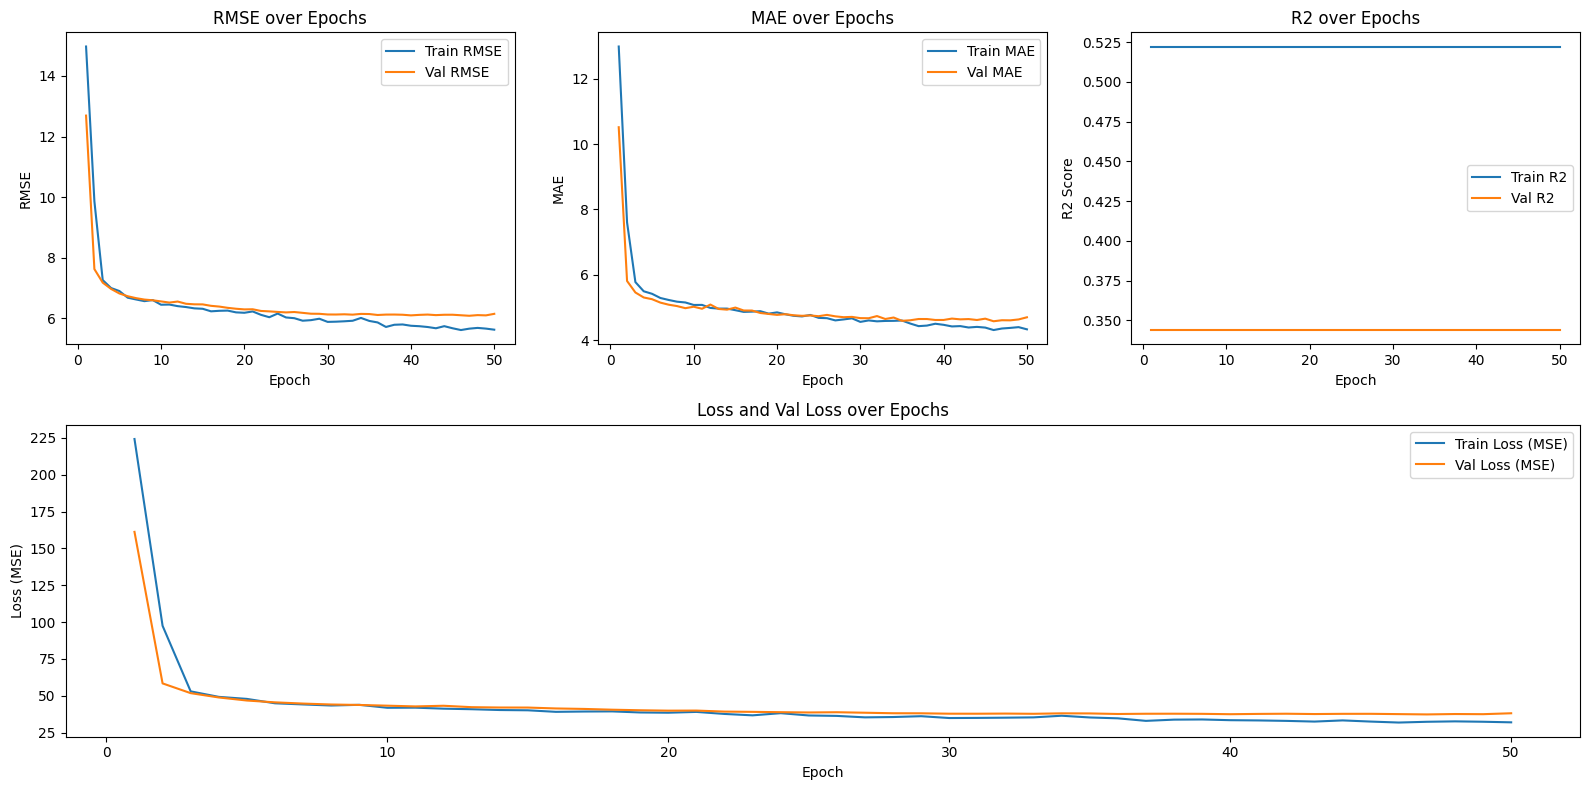

In [57]:
# Dropout is handled within the create_functional_model function
regularizer = tf.keras.regularizers.l2(0.001)
model_f3 = create_functional_model(N_FEATURES, layers=[128, 64], activation=tf.keras.layers.LeakyReLU(alpha=0.01), regularizer=regularizer, dropout_rate=0.2, optimizer=Adam(learning_rate=0.001))
history_f3 = run_dl_experiment(model_f3, "MLP-F-3: Dropout Regularization (0.2)", X_train_processed, Y_train_array, X_val_processed, Y_val_array)



From the above results, we see a slight increase in performance. The RMSE and R2 are slightly changing. This suggests a better look into fine tuning other relevant hyperparameters as well.

# Part 4: Results, Visualizations, and Comparison

## 4.1 Comparison of Final Results

Below is a final, comprehensive, systematic results table is mandatory for comparison, clearly documenting the model, hyperparameters, and evaluation metrics (RMSE and $R^2$). This facilitates critical discussion in the final report.

In [58]:
# Combine and format results
df_ml = pd.DataFrame(results_ml)
df_dl = pd.DataFrame(results_dl)

# Ensure R2 is numeric for sorting purposes, then convert back to string
df_ml['R2 Score_temp'] = df_ml['R2 Score'].astype(float)
df_dl['R2 Score_temp'] = df_dl['R2 Score'].astype(float)

# Sort by R2 Score (Best performance first)
df_ml = df_ml.sort_values(by='R2 Score_temp', ascending=False).drop(columns=['R2 Score_temp'])
df_dl = df_dl.sort_values(by='R2 Score_temp', ascending=False).drop(columns=['R2 Score_temp'])

# Combine the top performing experiments
top_ml = df_ml.head(5)
top_dl = df_dl.head(5)

df_final_comparison = pd.concat([top_ml, top_dl]).reset_index(drop=True)

print("### Traditional ML Results (Top 5 Ranked by R2) ###")
print(top_ml.to_markdown(index=False))

print("\n### Deep Learning Results (Top 5 Ranked by R2) ###")
print(top_dl.to_markdown(index=False))

### Traditional ML Results (Top 5 Ranked by R2) ###


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

## 4.3 Performance Visualization Of the Best Model

Next, let's visualize the best performing model.

Visualizing the actual vs. predicted values helps assess model performance, particularly the tendency for models to under- or over-predict the yield rate. This scatter plot directly illustrates the goodness of fit ($R^2$).

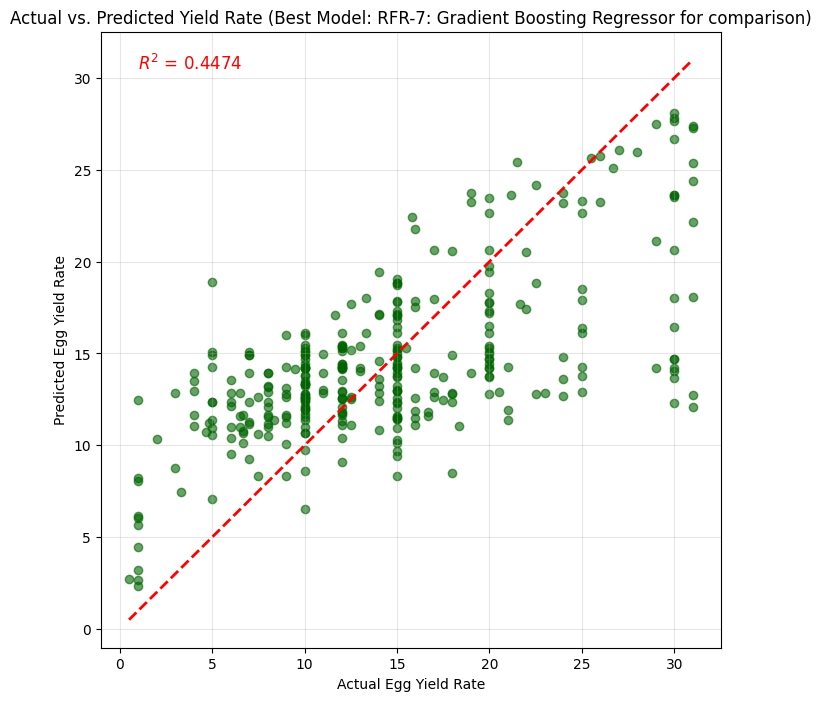

In [ ]:
# Select the single best overall model
best_model_name = df_final_comparison.iloc[0]['Model']
best_exp_name = df_final_comparison.iloc[0]['Experiment']

# Re-evaluate the best model for prediction clarity
Y_pred_best = gbr_model.predict(X_test_processed)
r2_best = r2_score(Y_test_array, Y_pred_best)

plt.figure(figsize=(8, 8))
plt.scatter(Y_test_array, Y_pred_best, alpha=0.6, color='darkgreen')
plt.plot([Y_test_array.min(), Y_test_array.max()], [Y_test_array.min(), Y_test_array.max()], 'r--', lw=2, label='Perfect Prediction (y=x)')
plt.title(f'Actual vs. Predicted Yield Rate (Best Model: {best_exp_name})')
plt.xlabel('Actual Egg Yield Rate')
plt.ylabel('Predicted Egg Yield Rate')
plt.text(Y_test_array.min() + 0.5, Y_test_array.max() - 0.5, f'$R^2$ = {r2_best:.4f}', fontsize=12, color='red')
plt.grid(True, alpha=0.3)
plt.show()